
# Mann Eddy Lifetime Linear Regression

This example demonstrates the a simple configuration of ``DRDMannTurb`` to spectra fitting while using a linear approximation to the Mann eddy lifetime function (in log-log space) under the Kaimal one-point spectra.

For reference, the full Mann eddy lifetime function is given by 

\begin{align}\tau^{\mathrm{IEC}}(k)=\frac{(k L)^{-\frac{2}{3}}}{\sqrt{{ }_2 F_1\left(1 / 3,17 / 6 ; 4 / 3 ;-(k L)^{-2}\right)}}\end{align}

where the hypergeometric function can only be evaluated on the CPU. The purpose of this example is to show how a GPU kernel of a linear approximation (in log-log space) of the Mann eddy lifetime can be generated automatically to speed up tasks that require the GPU. As before, the Kaimal spectra is used for the one-point-spectra model. 

The external API works the same as with other models, but the following may speed up some tasks that rely exclusively on the Mann eddy lifetime function. 


## Import packages

First, we import the packages we need for this example.



In [1]:
import torch
import torch.nn as nn

from drdmannturb import EddyLifetimeType
from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

device = "cuda" if torch.cuda.is_available() else "cpu"

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

Set up physical parameters and domain associated with the Kaimal spectrum. We perform the spectra fitting over the $k_1$ space :math:[10^{{-1}}, 10^2]`
with 20 points.



In [2]:
# Scales associated with Kaimal spectrum
L = 0.59  # length scale
Gamma = 3.9  # time scale
sigma = 3.2  # energy spectrum scale

domain = torch.logspace(-1, 2, 20)

## ``CalibrationProblem`` Construction
The following cell defines the ``CalibrationProblem`` using default values
for the ``NNParameters`` and ``LossParameters`` dataclasses. Importantly,
these data classes are not necessary, see their respective documentations for the default values.
The current set-up involves using the Mann model for the eddy lifetime function, meaning no
neural network is used in learning the $\tau$ function. Additionally, the physical parameters
are taken from the reference values for the Kaimal spectra. Finally, in this scenario the regression
occurs as an MSE fit to the spectra, which are generated from Mann turbulence (i.e. a synthetic data fit).
The ``EddyLifetimeType.MANN_APPROX`` argument determines the type of eddy lifetime function to use.
Here, we will employ a linear regression to determine a surrogate eddy lifetime function. Using one
evaluation of the Mann function on the provided spectra (here we are just taking it as if it's from a Mann model)
which can be done from either synthetic or real-world data. In normal space, this is a function of the form $` \exp(\alpha \boldsymbol{k} + \beta)$
where the $\alpha, \beta$ are coefficients determined by the linear regression in log-log space.



In [3]:
pb = CalibrationProblem(
    nn_params=NNParameters(
        nlayers=2,
        hidden_layer_sizes=[10, 10],
        activations=[nn.ReLU(), nn.ReLU()],
    ),
    prob_params=ProblemParameters(
        nepochs=10, eddy_lifetime=EddyLifetimeType.MANN_APPROX
    ),
    loss_params=LossParameters(),
    phys_params=PhysicalParameters(L=L, Gamma=Gamma, sigma=sigma, domain=domain),
    device=device,
)

## Data Generation
In the following cell, we construct our $k_1$ data points grid and
generate the values. ``Data`` will be a tuple ``(<data points>, <data values>)``.
It is worth noting that the second element of each tuple in ``DataPoints`` is the corresponding
reference height, which we have chosen to be uniformly $1$.



In [4]:
k1_data_pts = domain
DataPoints = [(k1, 1) for k1 in k1_data_pts]

Data = OnePointSpectraDataGenerator(data_points=DataPoints).Data

## Calibration
Now, we fit our model. ``CalibrationProblem.calibrate`` takes the tuple ``Data``
which we just constructed and performs a typical training loop.



In [5]:
optimal_parameters = pb.calibrate(data=Data)

Mann Linear Approximation R2 Score in log-log space: 0.9920140661948813
Initial loss: 1.881223142108241


  0%|                                                                                          | 0/10 [00:00<?, ?it/s]

 10%|████████▏                                                                         | 1/10 [00:02<00:21,  2.42s/it]

 30%|████████████████████████▌                                                         | 3/10 [00:02<00:04,  1.50it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [00:02<00:00,  4.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.69it/s]

Spectra fitting concluded with final loss: 0.058471332971692394


The following plot shows the best fit to the synthetic Mann data. Notice that
the eddy lifetime function is linear in log-log space and is a close approximation
to the Mann eddy lifetime function.



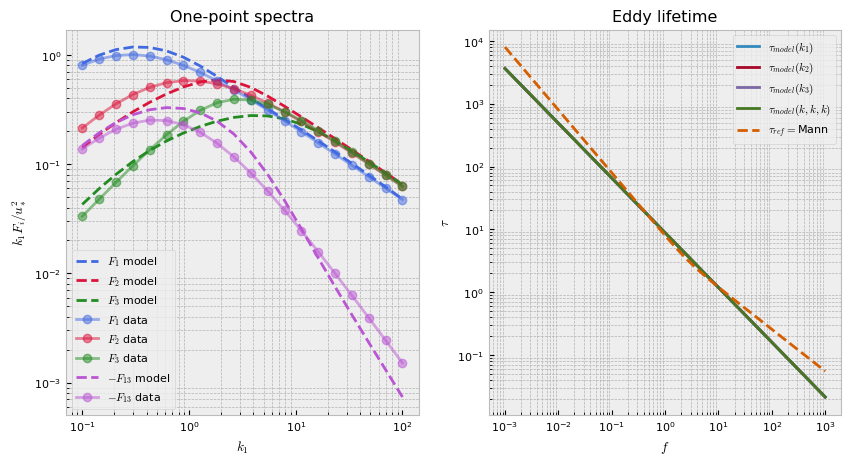

In [6]:
pb.plot()